<a href="https://colab.research.google.com/github/namtoptall/DataScience/blob/main/SkimLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SkimLit

In [1]:
# Kiểm tra GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Những gì chúng ta sẽ đề cập

Chúng ta sẽ thực hiện :

* Nhận dữ liệu chuỗi thời gian (giá lịch sử của Bitcoin)
  * Load dữ liệu chuỗi thời gian bằng mô-đun CSV của pandas/Python
* Định dạng dữ liệu cho bài toán chuỗi thời gian
  * Tạo tập huấn luyện và kiểm tra (sai cách)
  * Tạo tập huấn luyện và kiểm tra (đúng cách)
  * Trực quan hóa dữ liệu chuỗi thời gian
  * Biến dữ liệu chuỗi thời gian thành một bài toán học có giám sát (windowing)
  * Chuẩn bị dữ liệu đơn biến và đa biến (nhiều hơn một biến)
* Đánh giá mô hình dự báo chuỗi thời gian
* Thiết lập một chuỗi các thử nghiệm mô hình học sâu
  * Mạng dày đặc (được kết nối đầy đủ)
  * Mô hình chuỗi (LSTM và 1D CNN)
  * Ensembling (kết hợp nhiều mô hình với nhau)
  * Mô hình đa biến
  * Sao chép thuật toán N-BEATS bằng cách sử dụng phân lớp TensorFlow layer
* Tạo modelling checkpoint để lưu mô hình hoạt động tốt nhất trong quá trình huấn luyện
* Đưa ra dự đoán (dự báo) với mô hình chuỗi thời gian
* Tạo khoảng thời gian dự đoán cho các dự báo mô hình chuỗi thời gian
* Thảo luận về hai loại không chắc chắn khác nhau trong ML (data uncertainty và model uncertainty)
* Chứng minh lý do tại sao dự báo trong một hệ thống mở là BS (bài toán gà tây)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 12.08 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Kiểm tra xem có những file nào trong tập dữ liệu PubMed_20K
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Bắt đầu sử dụng tập dữ liệu 20k
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Kiểm tra tất cả filename trong directory đích
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Tiền xử lý dữ liệu

In [6]:
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split)
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples

In [9]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev là một tên gọi khác của validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 864 ms, sys: 181 ms, total: 1.05 s
Wall time: 4.12 s


(180040, 30212, 30135)

In [10]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
# turn the dictionaries into pandas
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [12]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

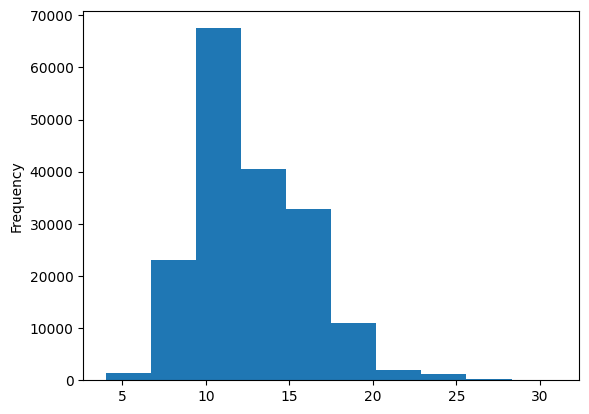

In [13]:
train_df.total_lines.plot.hist()

In [14]:
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Tạo nhãn dạng số (mô hình học máy cần các nhãn dạng số)

In [15]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Kiểm tra xem các nhãn huấn luyện trông như thế nào
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
# Trích xuất nhãn (cột "target") và mã hóa chúng thành số nguyên
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Kiểm tra xem nhãn huấn luyện trông như thế nào
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
num_classes = len(label_encoder.classes_)
class_name = label_encoder.classes_
class_name, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

## Model 0: Tạo mô hình cơ sở
Mô hình đầu tiên của chúng ta sẽ là TF-IDF Multinomial Naive Bayes, theo gợi ý từ [machine learning map của Scikit-Learn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

Để xây dựng, chúng ta sẽ tạo `Pipeline` của Scikit-Learn, sử dụng lớp [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) để chuyển đổi các câu abstract thành số bằng cách sử dụng thuật toán TF-IDF, sau đó tìm hiểu cách phân loại các câu bằng cách sử dụng thuật toán [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create the pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])
# fir the model pipeline
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
model_0.score(train_sentences, train_labels_encoded)

0.7516829593423684

In [20]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [21]:
# downlaod support functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-31 13:27:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-31 13:27:35 (77.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [22]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Chuẩn bị dữ liệu cho các mô hình chuỗi sâu


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [24]:
# find the average length of the sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

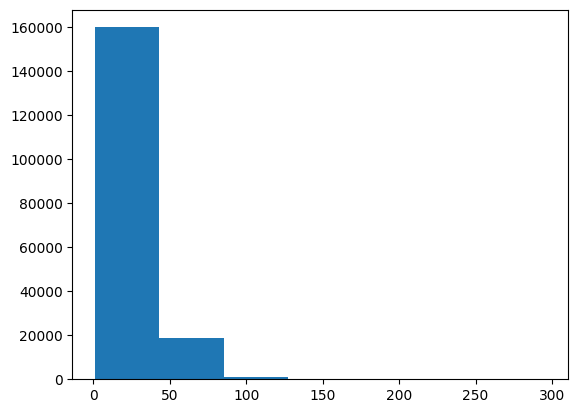

In [25]:
# plot the distribution ""
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [26]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [27]:
max(sent_lens)

296

In [28]:
max_tokens = 68000

In [29]:
# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [30]:
text_vectorizer.adapt(train_sentences)

In [31]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}\n")
print(f"Vectorized: {text_vectorizer([target_sentence])}")


Text:
meat provides several nutrients identified as important in maintaining immune function and lean body mass .

Vectorized: [[5193  828  881 8016  526   25  430    5 2278  988  149    3 2880  239
   385    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [32]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Top 5 words: {rct_20k_text_vocab[:5]}")
print(f"Bottom 5 words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Top 5 words: ['', '[UNK]', 'the', 'and', 'of']
Bottom 5 words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
# Tìm cấu hình của text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [34]:
# create token embedding layer
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding" )

# print the embeddings
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n{vectorized_sentence}\n")
print(f"Output shape: {token_embed(vectorized_sentence).shape}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Embedded sentence:\n{embedded_sentence}")

Sentence before vectorization:
meat provides several nutrients identified as important in maintaining immune function and lean body mass .

Sentence after vectorization:
[[5193  828  881 8016  526   25  430    5 2278  988  149    3 2880  239
   385    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Output shape: (1, 55, 128)
Embedded sentence:
[[[ 0.0412592  -0.00747684  0.01050017 ... -0.02575753  0.0453539
   -0.01693344]
  [ 0.02389891  0.04667172  0.02756676 ... -0.04503064 -0.02846773
    0.020951  ]
  [ 0.04462652 -0.04876567  0.02254933 ...  0.02287556 -0.03281838
   -0.03673242]
  ...
  [-0.02546455 -0.02143897 -0.00472969 ...  0.01708739  0.01288802
   -0.01032957]
  [-0.02546455 -0.02143897 -0.00472969 ...  0.01708739  0.01288802
   -0.01032957]
  [-0.02546455 -0.02143897 -0.00472969 ...  0.01708739  0.01288802
   -0.01032

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE )
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D với token embedding

In [37]:
# create conv1f model for sequential processing
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters=64, kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs,name="model_1_conv1d")

In [38]:
#compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [39]:
# fit the model with 10% of dataset
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=5,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))


Epoch 1/5
562/562 [==============================] - 75s 131ms/step - loss: 0.9134 - accuracy: 0.6378 - val_loss: 0.6851 - val_accuracy: 0.7380
Epoch 2/5
562/562 [==============================] - 70s 125ms/step - loss: 0.6560 - accuracy: 0.7568 - val_loss: 0.6347 - val_accuracy: 0.7683
Epoch 3/5
562/562 [==============================] - 70s 124ms/step - loss: 0.6156 - accuracy: 0.7736 - val_loss: 0.5971 - val_accuracy: 0.7846
Epoch 4/5
562/562 [==============================] - 69s 122ms/step - loss: 0.5877 - accuracy: 0.7889 - val_loss: 0.5795 - val_accuracy: 0.7869
Epoch 5/5
562/562 [==============================] - 69s 122ms/step - loss: 0.5899 - accuracy: 0.7909 - val_loss: 0.5614 - val_accuracy: 0.7975


In [40]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5601 - accuracy: 0.8007


[0.5601013898849487, 0.8006752133369446]

In [41]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

945/945 [==============================] - 5s 5ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 2, 2, 2, 4, 1])>

In [42]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.06752283860718,
 'precision': 0.8009830254972893,
 'recall': 0.8006752283860717,
 'f1': 0.7974470564497274}

In [43]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [44]:
# random embdeeing
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence}\n")
print(f"Output shape: {use_embedded_sentence.shape}")

Random training sentence:
our findings showed that early initiation of crrt is associated with favorable clinical outcomes in ards patients , which might be due to the reduced serum and balf tgf-@ levels through crrt .

Sentence after embedding:
[[-6.63379133e-02  2.33501643e-02 -1.39552057e-02 -2.48290617e-02
   3.21764089e-02  5.12809604e-02 -3.13679166e-02 -6.03649169e-02
   4.25038971e-02  4.95154671e-02  8.87214392e-02  1.17802608e-03
  -5.15942276e-03  7.34766573e-02  4.29778956e-02  1.97730307e-02
  -9.08133164e-02 -4.13917713e-02 -1.37778949e-02  2.34142840e-02
  -2.60340385e-02  7.51634091e-02  2.57583777e-03  3.98894772e-02
  -1.23453606e-02  3.07760965e-02 -6.09753504e-02  1.63774530e-03
  -3.21225561e-02  8.12143683e-02  5.95496222e-03  9.23663005e-02
   3.26137505e-02  5.31914160e-02 -7.03287646e-02 -5.86274639e-02
  -5.91339581e-02 -5.60471192e-02 -2.66286097e-02 -6.71703070e-02
  -5.90578020e-02  9.84004349e-04 -2.59251315e-02 -4.39124852e-02
   2.50312947e-02  4.8875134

## Model 2: Feature extraction với pretrained token embeddings

In [45]:
# define model using feature extractor with tfHublayer
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x= layers.Dense(units=128,activation="relu")(pretrained_embedding)
outputs = layers.Dense(units=5,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_use")

In [46]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model_2_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [47]:
# Khớp mô hình feature extractor cho 3 epoch
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=5,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 13s 17ms/step - loss: 0.9147 - accuracy: 0.6508 - val_loss: 0.7972 - val_accuracy: 0.6892
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7703 - accuracy: 0.6997 - val_loss: 0.7571 - val_accuracy: 0.7058
Epoch 3/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7548 - accuracy: 0.7106 - val_loss: 0.7422 - val_accuracy: 0.7121
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7215 - accuracy: 0.7222 - val_loss: 0.7127 - val_accuracy: 0.7281
Epoch 5/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7296 - accuracy: 0.7198 - val_loss: 0.6911 - val_accuracy: 0.7337


In [48]:
# Đánh giá trên toàn bộ tập dữ liệu kiểm định
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7005 - accuracy: 0.7325


[0.7005354166030884, 0.732523500919342]

In [49]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
# Tính kết quả từ TF Hub pretrained embeddings results trên tập kiểm định
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

945/945 [==============================] - 11s 11ms/step


{'accuracy': 73.25235005957897,
 'precision': 0.7285728943600375,
 'recall': 0.7325235005957897,
 'f1': 0.726706279596351}

### Model 3: Conv1D với character embeddings

Sự khác biệt giữa character embedding và token embedding là **character embedding** được tạo bằng cách sử dụng các chuỗi được chia ra thành các ký tự (ví dụ: `hello` -> [`h`, `e`, `l`, `l`, `o`]) trong khi đó, **token embedding** được tạo ra dựa trên các chuỗi được chia thành các token.


In [50]:
# function to split charactors into char
def split_characters(text):
    return " ".join(list(text))
split_characters(random_training_sentence)

'o u r   f i n d i n g s   s h o w e d   t h a t   e a r l y   i n i t i a t i o n   o f   c r r t   i s   a s s o c i a t e d   w i t h   f a v o r a b l e   c l i n i c a l   o u t c o m e s   i n   a r d s   p a t i e n t s   ,   w h i c h   m i g h t   b e   d u e   t o   t h e   r e d u c e d   s e r u m   a n d   b a l f   t g f - @   l e v e l s   t h r o u g h   c r r t   .'

In [51]:
# split the datasets into characters
train_chars = [split_characters(sentence) for sentence in train_sentences]
val_chars = [split_characters(sentence)for sentence in val_sentences]
test_chars = [split_characters(sentence)for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [52]:
# Độ dài ký tự trung bình là bao nhiêu?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

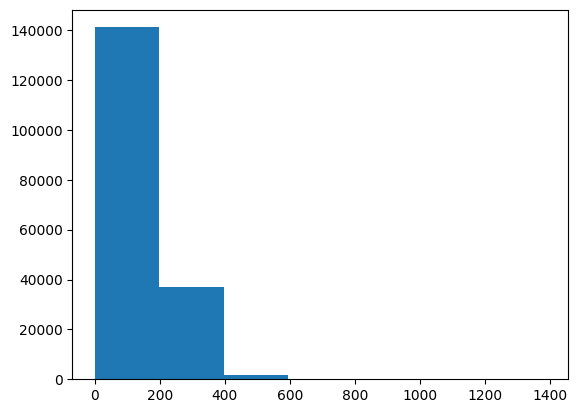

In [53]:
# Kiểm tra phân phối của các chuỗi ở cấp độ ký tự
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [54]:
# Tìm độ dài ký tự chiếm 95% chuỗi
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [55]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [56]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [57]:
# Kiểm tra đặc điểm của character vocabulary
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [58]:
# Kiểm tra character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
a   t o t a l   o f   @ , @   p a i r s   w e r e   g e n e r a t e d   .

Length of chars: 30

Vectorized chars:
[[ 5  3  7  3  5 12  7 17 14  5  4  8  9 20  2  8  2 18  2  6  2  8  5  3
   2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [59]:
# Tạo char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # số lượng ký tự khác nhau
                              output_dim=25, # kích thước embedding của mỗi ký tự (giống như Hình 1 trong https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # không sử dụng mask (điều này sẽ làm rối tung model_5 nếu được đặt thành True)
                              name="char_embed")

# Kiểm tra character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a   t o t a l   o f   @ , @   p a i r s   w e r e   g e n e r a t e d   .

Embedded chars (after vectorization and embedding):
[[[-0.03126861 -0.01315769  0.00817017 ...  0.02906961 -0.00378478
   -0.03753582]
  [ 0.0211532  -0.02300873  0.03908833 ...  0.03382814 -0.00058787
    0.03096091]
  [-0.02970401 -0.02537271 -0.03488623 ...  0.03358329 -0.00417714
    0.02497431]
  ...
  [ 0.00546107 -0.00307852 -0.0322804  ...  0.02093843  0.01128223
   -0.00144489]
  [ 0.00546107 -0.00307852 -0.0322804  ...  0.02093843  0.01128223
   -0.00144489]
  [ 0.00546107 -0.00307852 -0.0322804  ...  0.02093843  0.01128223
   -0.00144489]]]

Character embedding shape: (1, 290, 25)


In [60]:
# Tạo Conv1D chỉ ở cấp độ ký tự
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Biên dịch mô hình
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [61]:
# Tạo char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [62]:
# Khớp mô hình chỉ ở cấp độ ký tự
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 22ms/step - loss: 1.2512 - accuracy: 0.4860 - val_loss: 1.0321 - val_accuracy: 0.5951
Epoch 2/3
562/562 [==============================] - 12s 22ms/step - loss: 0.9978 - accuracy: 0.5996 - val_loss: 0.9294 - val_accuracy: 0.6340
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.9221 - accuracy: 0.6378 - val_loss: 0.8647 - val_accuracy: 0.6652


In [63]:
# Đánh giá model_3 trên toàn bộ validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.8838 - accuracy: 0.6558


[0.8838433623313904, 0.6557990312576294]

In [64]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
# Tính kết quả chỉ của của mô hình Conv1D ký tự
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

945/945 [==============================] - 6s 6ms/step


{'accuracy': 65.57990202568516,
 'precision': 0.653212988701653,
 'recall': 0.6557990202568516,
 'f1': 0.6475621980742489}

## Model 4: Kết hợp pretrained token embeddings + character embeddings (hybrid embedding layer)

In [65]:
#1 set the token inputs
token_inputs = layers.Input(shape=[],dtype="string",name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(units=128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

In [66]:
# 2. Thiết lập char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM hiển thị trong Hình 1 của https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


In [67]:
# merge
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(units=200,activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer)

In [68]:
# Lấy summary của mô hình token và character
model_4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']   

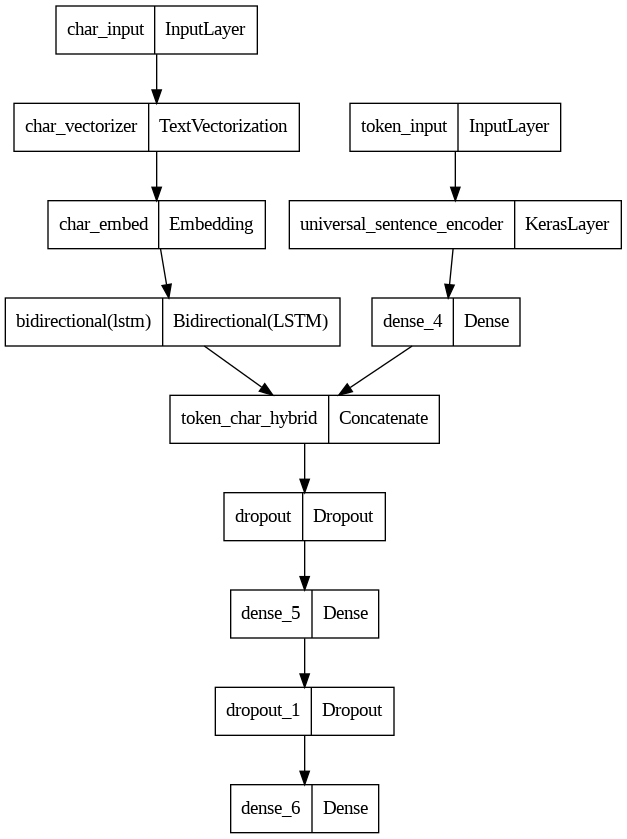

In [69]:
# Vẽ mô hình hybrid token và character
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [70]:
# Biên dịch mô hình token char
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
# Kết hợp chars và tokens thành một dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # tạo dữ liệu
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # tạo nhãn
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # kết hợp dữ liệu và nhãn

# Dữ liệu prefetch và batch train
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Lặp lại các bước tương tự với dữ liệu kiểm định
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
# Kiểm tra training char và token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [73]:
# Khớp mô hình trên tokens và chars
model_4_history = model_4.fit(train_char_token_dataset, # huấn luyện trên dataset của token và kí tự
                              steps_per_epoch=int(0.25 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.25 * len(val_char_token_dataset)))

Epoch 1/5
1406/1406 [==============================] - 310s 217ms/step - loss: 0.8599 - accuracy: 0.6648 - val_loss: 0.7104 - val_accuracy: 0.7254
Epoch 2/5
1406/1406 [==============================] - 305s 217ms/step - loss: 0.7460 - accuracy: 0.7153 - val_loss: 0.6624 - val_accuracy: 0.7483
Epoch 3/5
1406/1406 [==============================] - 305s 217ms/step - loss: 0.7209 - accuracy: 0.7262 - val_loss: 0.6451 - val_accuracy: 0.7549
Epoch 4/5
1406/1406 [==============================] - 306s 218ms/step - loss: 0.7014 - accuracy: 0.7335 - val_loss: 0.6295 - val_accuracy: 0.7614
Epoch 5/5
   3/1406 [..............................] - ETA: 6:41 - loss: 0.7586 - accuracy: 0.7500

1406/1406 [==============================] - 22s 15ms/step - loss: 0.7586 - accuracy: 0.7500 - val_loss: 0.6306 - val_accuracy: 0.7617


In [74]:
# Đánh giá trên toàn bộ tập kiểm định
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 52s 55ms/step - loss: 0.6257 - accuracy: 0.7615


[0.6257283687591553, 0.7615185976028442]

In [75]:
# Đưa ra dự đoán với mô hình token-character hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
# Biến xác suất dự đoán thành lớp dự đoán
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
# Nhận kết quả của mô hình token-char-hybrid
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 53s 55ms/step


{'accuracy': 76.15186018800478,
 'precision': 0.7584687128648332,
 'recall': 0.7615186018800477,
 'f1': 0.757950691054568}

## Model 5: Transfer Learning với pretrained token embeddings + character embeddings + positional embeddings


In [76]:
# Kiểm tra training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


### Tạo positional embedding
Chúng ta đã nói khá nhiều về positional embedding, hãy tạo chúng thôi.

Vì các cột `"line_number"` và `"total_line"` ở dạng số, nên chúng ta có thể truyền chúng vào mô hình

Nhưng để tránh mô hình nghĩ rằng dòng có `"line_number"=5` lớn hơn năm lần so với dòng có `"line_number"=1`, nên chúng ta sẽ sử dụng mã hóa one-hot để mã hóa các đặc trưng `"line_number"` và `"total_lines"`.
`tf.one_hot` trả về tensor được mã hóa one-hot. Nó chấp nhận một mảng (hoặc tensor) làm đầu vào và tham số `depth` xác định chiều của tensor được trả về.

Để biết nên thiết lập tham số `depth` như thế nào, hãy kiểm tra phân phối của cột `"line_number"`.


<Axes: ylabel='Frequency'>

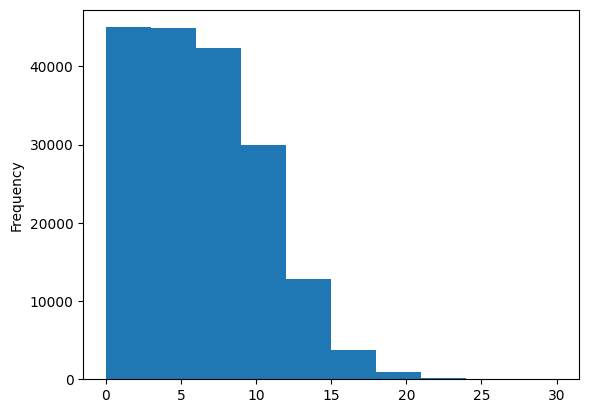

In [77]:
# Kiểm tra phân phối của cột "line_number"
train_df.line_number.plot.hist()

In [78]:
# Sử dụng TensorFlow để tạo các tensor được mã hóa one-hot cho cột "line_number"
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

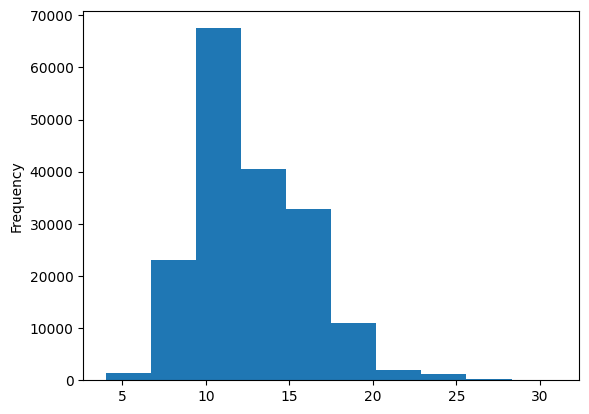

In [79]:
# Kiểm tra phân phối của total lines
train_df.total_lines.plot.hist();

In [80]:
 # Kiểm tra độ bao phủ của giá trị "total_lines" 20
np.percentile(train_df.total_lines, 98) # giá trị 20 chiếm 98% mẫu

21.0

In [81]:
# Sử dụng TensorFlow để tạo các tensor được mã hóa one-hot cho cột "total_lines"
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Kiểm tra shape và các mẫu của total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Xây dựng mô hình tribrid embedding


In [82]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Kết hợp token embeddings và char embeddings thành hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Kết hợp positional embeddings với token và char embeddings đã kết hợp thành tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Tạo output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Kết hợp thành một mô hình
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [83]:
# Lấy summary của mô hình token, char và positional embedding
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_embed (Embedding)      (None, 290, 25)              1750      ['char_vectorizer[2][0]'

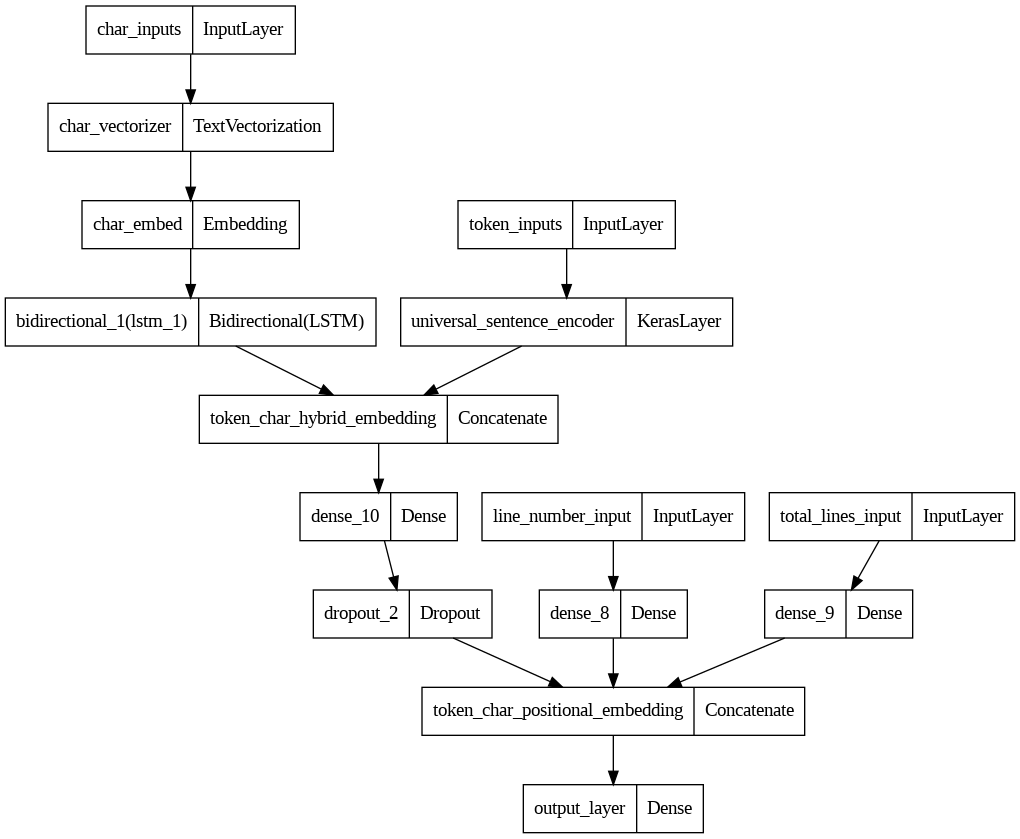

In [84]:
# Vẽ mô hình token, char, positional embedding
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [85]:
# Kiểm tra những layer nào của mô hình có thể huấn luyện
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7eec4b9be320> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7eebfd175900> True
<keras.src.engine.input_layer.InputLayer object at 0x7eebfaa0aad0> True
<keras.src.layers.core.embedding.Embedding object at 0x7eebfd1b4cd0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7eec52052b00> False
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7eec540eb940> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7eecaaf929e0> True
<keras.src.engine.input_layer.InputLayer object at 0x7eebfaf639d0> True
<keras.src.engine.input_layer.InputLayer object at 0x7eebfc792470> True
<keras.src.layers.core.dense.Dense object at 0x7eec4b663460> True
<keras.src.layers.core.dense.Dense object at 0x7eec540e8d00> True
<keras.src.layers.core.dense.Dense object at 0x7eec4b05e980> True
<keras.src.layers.regularization.dropout.Dropout object at 0x7eec4b6600d0> True
<keras.src.layers.merging.c

In [86]:
# Biên dịch mô hình token, char, positional embedding
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # thêm label smoothing (các mẫu thực sự tự tin sẽ làm mịn một chút)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [87]:
# Tạo training và validation datasets (tất cả 4 loại đầu vào)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # số dòng
                                                                train_total_lines_one_hot, # tổng số dòng
                                                                train_sentences, # huấn luyện token
                                                                train_chars)) # huấn luyện char
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # huấn luyện nhãn
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # kết hợp dữ liệu và nhãn
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # biến thành các batch và prefetch một cách hợp lý

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # biến thành các batch và prefetch một cách hợp lý

# Kiểm tra shape đầu vào
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [88]:
# Khớp mô hình token, char và positional embedding
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 143s 243ms/step - loss: 1.0976 - accuracy: 0.7282 - val_loss: 0.9883 - val_accuracy: 0.8005
Epoch 2/10
562/562 [==============================] - 131s 233ms/step - loss: 0.9755 - accuracy: 0.8121 - val_loss: 0.9575 - val_accuracy: 0.8241
Epoch 3/10
562/562 [==============================] - 132s 235ms/step - loss: 0.9607 - accuracy: 0.8183 - val_loss: 0.9500 - val_accuracy: 0.8295
Epoch 4/10
562/562 [==============================] - 135s 241ms/step - loss: 0.9527 - accuracy: 0.8292 - val_loss: 0.9417 - val_accuracy: 0.8285
Epoch 5/10
562/562 [==============================] - 132s 234ms/step - loss: 0.9487 - accuracy: 0.8296 - val_loss: 0.9342 - val_accuracy: 0.8391
Epoch 6/10
562/562 [==============================] - 130s 232ms/step - loss: 0.9522 - accuracy: 0.8250 - val_loss: 0.9305 - val_accuracy: 0.8441
Epoch 7/10
562/562 [==============================] - 136s 242ms/step - loss: 0.9409 - accuracy: 0.8323 - val_loss: 0.9315 -

In [89]:
# Đưa ra dự đoán với mô hình token-char-positional hybrid
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
# Tính toán các kết quả của mô hình token-char-positional hybrid
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

945/945 [==============================] - 59s 61ms/step


{'accuracy': 84.71468290745399,
 'precision': 0.8485484050220125,
 'recall': 0.8471468290745399,
 'f1': 0.8438067755376806}

In [90]:
# Kết hợp các kết quả của mô hình thành một DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.067523,0.800983,0.800675,0.797447
pretrained_token_embed,73.252350,0.728573,0.732524,0.726706
custom_char_embed_conv1d,65.579902,0.653213,0.655799,0.647562
hybrid_char_token_embed,76.151860,0.758469,0.761519,0.757951
tribrid_pos_char_token_embed,84.714683,0.848548,0.847147,0.843807


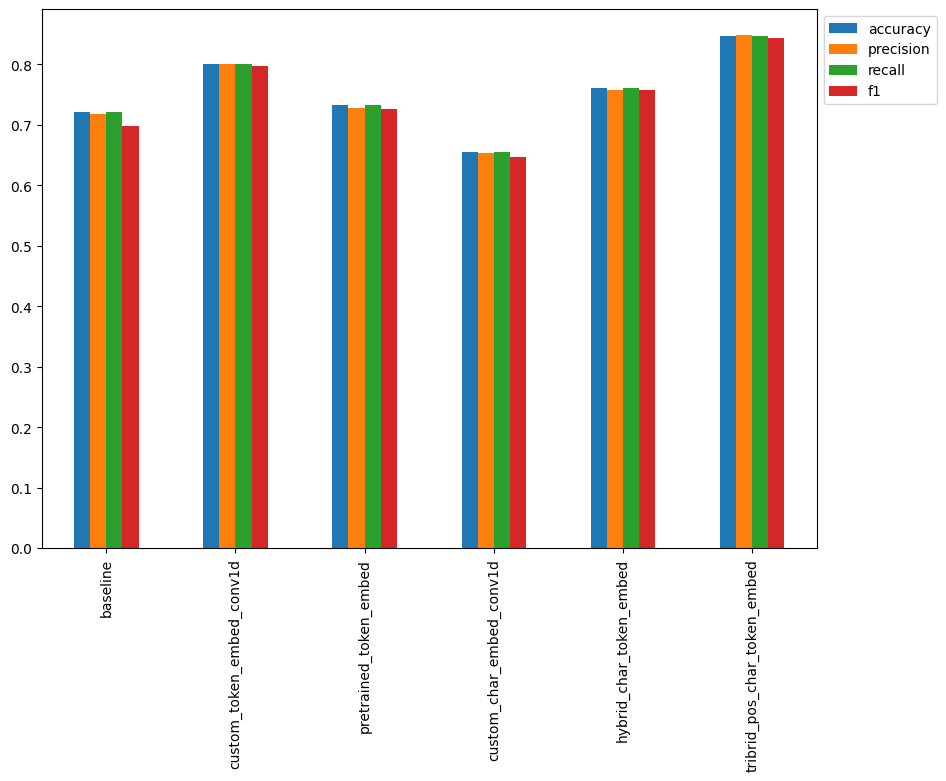

In [91]:
# Giảm accuracy xuống cùng thang đo như các phép đo khác
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# Vẽ và so sánh các kết quả của mô hình
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [92]:
# Tạo test dataset batch và prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Kiểm tra shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [93]:
# Đưa ra dự đoán trên tập dữ liệu kiểm tra
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 56s 59ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 4, 0])>

In [94]:
# Kiểm tra các dự đoán của loaded model test
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 84.22100547536088,
 'precision': 0.842245612691153,
 'recall': 0.8422100547536088,
 'f1': 0.8388983261247088}

In [95]:
%%time
# Lấy danh sách tên lớp của các dự đoán kiểm tra
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 7.85 s, sys: 27.4 ms, total: 7.87 s
Wall time: 7.9 s


['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESU

In [96]:
# Tạo test dataframe đã làm phong phú dự đoán
test_df["prediction"] = test_pred_classes # tạo cột với tên test prediction class
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # lấy xác suất dự đoán tối đa
test_df["correct"] = test_df["prediction"] == test_df["target"] # tạo cột nhị phân để biết dự đoán có đúng hay không
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,9,OBJECTIVE,0.382803,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,9,METHODS,0.496849,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,9,METHODS,0.890456,False
3,RESULTS,survival analyses were used to assess the asso...,3,9,METHODS,0.722498,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,9,RESULTS,0.784134,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,9,RESULTS,0.868227,True
6,RESULTS,multivariable analyses revealed that patients ...,6,9,RESULTS,0.516285,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,9,CONCLUSIONS,0.414303,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,9,RESULTS,0.492243,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,13,BACKGROUND,0.649864,True


In [97]:
# Tìm 100 mẫu sai nhiều nhất (lưu ý: 100 là số tùy ý, bạn có thể xem qua tất cả nếu muốn)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,7,METHODS,0.966882,False
8545,METHODS,pretest-posttest .,1,12,BACKGROUND,0.955011,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,14,METHODS,0.948922,False
1221,RESULTS,data were collected prospectively for @ months...,3,14,METHODS,0.938925,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,19,BACKGROUND,0.938857,False
...,...,...,...,...,...,...,...
27814,BACKGROUND,secondary outcomes are patient-rated cosmesis ...,3,11,METHODS,0.854285,False
29320,RESULTS,the patients were divided into @ groups : @ un...,5,14,METHODS,0.854039,False
29313,CONCLUSIONS,the rate of arc definite st in stable patients...,9,11,RESULTS,0.853427,False
29835,CONCLUSIONS,"by age @ years , subjects remained small and t...",10,14,RESULTS,0.850969,False


## 🛠 Bài tập thực hành
> **Lưu ý:** Các bạn cần làm phần bài tập này để chuẩn bị cho phiên review lab.

1. Huấn luyện `model_5` trên tất cả dữ liệu trong tập dữ liệu huấn luyện trong nhiều epoch cho đến khi nó ngừng cải thiện. Vì quá trình này có thể tốn một chút thời gian, bạn có thể sử dụng:
  * [`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) để chỉ lưu trọng số tốt nhất của mô hình.
  * [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) để dừng huấn luyện mô hình sau khi validation loss đã ngừng cải thiện trong ~3 epoch.



2. Xem [hướng dẫn của Keras về cách sử dụng pretrained GloVe embedding](https://keras.io/examples/nlp/pretrained_word_embeddings/). Bạn có thể làm cho điều này hoạt động với một trong các mô hình của chúng ta không?
  * Gợi ý: Bạn sẽ muốn kết hợp nó với một layer token [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) tùy chỉnh.
  * Bạn có thể tinh chỉnh các GloVe embedding hoặc đóng băng chúng.

3. Hãy thử thay thế TensorFlow Hub Universal Sentence Encoder pretrained  embedding cho [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (mô hình ngôn ngữ được huấn luyện trước trên văn bản PubMed). Điều này có ảnh hưởng tới kết quả không?
  * Lưu ý: Việc sử dụng BERT PubMed expert pretrained embedding yêu cầu thêm một bước tiền xử lý cho các chuỗi (được trình bày chi tiết trong [hướng dẫn của TensorFlow Hub](https://tfhub.dev/google/experts/bert/pubmed/2)).
  * Mô hình BERT có đánh bại các kết quả được đề cập trong [tài liệu này](https://arxiv.org/pdf/1710.06071.pdf) không?

4. Điều gì xảy ra nếu chúng ta hợp nhất các đặc trưng `line_number` và `total_lines` cho từng chuỗi? Ví dụ: tạo đặc trưng `X_of_Y` thay thế? Điều này có ảnh hưởng tới chất lượng mô hình không?
  * Một ví dụ khác: `line_number=1` và `total_lines=11` biến thành `line_of_X=1_of_11`.

5. Viết một hàm (hoặc một chuỗi các hàm) để lấy một string abstract mẫu, tiền xử lý nó (theo cách tương tự mà mô hình đã huấn luyện), đưa ra dự đoán trên mỗi chuỗi trong abstract và trả về abstract ở định dạng:
  * `PREDICTED_LABEL`: `SEQUENCE`
  * `PREDICTED_LABEL`: `SEQUENCE`
  * `PREDICTED_LABEL`: `SEQUENCE`
  * `PREDICTED_LABEL`: `SEQUENCE`
  * ...
    * Bạn có thể tìm RCT abstract không có cấu trúc của riêng mình từ PubMed hoặc thử phần này từ: [*Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection*](https://pubmed.ncbi.nlm.nih.gov/22244707/).

In [99]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint = ModelCheckpoint(model_5,
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode='min')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               mode='min')

# Huấn luyện model với callbacks
history_model_5_new = model_5.fit(
    train_pos_char_token_dataset,  # Sử dụng dataset huấn luyện
    epochs=20,  # Số epoch tối đa
    validation_data=val_pos_char_token_dataset,  # Sử dụng dataset validation
    callbacks=[model_checkpoint, early_stopping]  # Sử dụng các callbacks đã tạo
)

Epoch 1/20
5627/5627 [==============================] - ETA: 0s - loss: 0.9267 - accuracy: 0.8464

AttributeError: 'Functional' object has no attribute 'format'